# Feature Importance

This notebook is responsible for evaluating the importance of each feature of the dataset. 

These results are also present in the paper related to the dataset, and for that reason this code is just to reconfirm which features most influence the "FWF" criteria.

The selection is done by usage of Boosting of Decision Trees (XGCBoost to more precise). The results prove that "Feed rate vf" and "Cutting speed vc" are indeed the features that most influence the results of "Flank Wear Failure (FWF)".

For this reason, these must involved in the calculation of wear in the degradation tool used.

Software Lab 2025 Group 25

File made by: Eduardo Silva (03805057)
eduardo.silva@tum.de

Documentation made by: Eduardo Silva (03805057)

# 1) Load the Dataset file

Loading the dataset to analyze its features and values.

In [1]:
from pathlib import Path
import pandas as pd

# Current working directory (notebook location)
BASE_DIR = Path.cwd()

# get the correct path for the dataset file (if locations are changed then this also need to be changed)
file_path = BASE_DIR.parent / "XAI_Drilling_Dataset.csv"
df = pd.read_csv(file_path)
print(df.head())

   ID  Cutting speed vc [m/min]  Spindle speed n [1/min]  Feed f [mm/rev]  \
0   1                     29.92                      794            0.218   
1   2                     29.85                      792            0.241   
2   3                     22.85                      606            0.183   
3   4                     29.60                      785            0.236   
4   5                     17.43                      462            0.246   

   Feed rate vf [mm/min]  Power Pc [kW]  Cooling [%] Material Drill Bit Type  \
0                    173         194.87           75        N              W   
1                    191         214.71           75        N              W   
2                    111          95.68           50        P              N   
3                    237         206.93           75        N              W   
4                    114          74.85           50        K              H   

   Process Time [sec]  Main Failure  BEF  CCF  FWF  WDF 

# 2) Analyzing Feature Importance for FWF

Usage of a Decision Tree model with the XGBClassifier class from xgboost. By using the "FWF" values as a target, the algorithm analyzes which features are more impactfull in the outcome. 

At the end, we plot a graph that shows which features have more "weight" for the decision making of FWF. We will use the most important distinct features in the degradation tool, to correctly and efficiently predict new scenarios for FWF.

   ID     VC   SS     FF   VF      PC  Cooling  Material  Drill Bit Type  \
0   1  29.92  794  0.218  173  194.87       75         1               2   
1   2  29.85  792  0.241  191  214.71       75         1               2   
2   3  22.85  606  0.183  111   95.68       50         2               1   
3   4  29.60  785  0.236  237  206.93       75         1               2   
4   5  17.43  462  0.246  114   74.85       50         0               0   

    Time  Main Failure  BEF  CCF  FWF  WDF  
0  19.26             0    0    0    0    0  
1  19.55             0    0    0    0    0  
2  36.16             0    0    0    0    0  
3  21.22             1    0    0    1    0  
4  33.56             0    0    0    0    0  


/home/myuser/anaconda3/envs/sl-siemens/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy: 1.0000


<Figure size 1000x600 with 0 Axes>

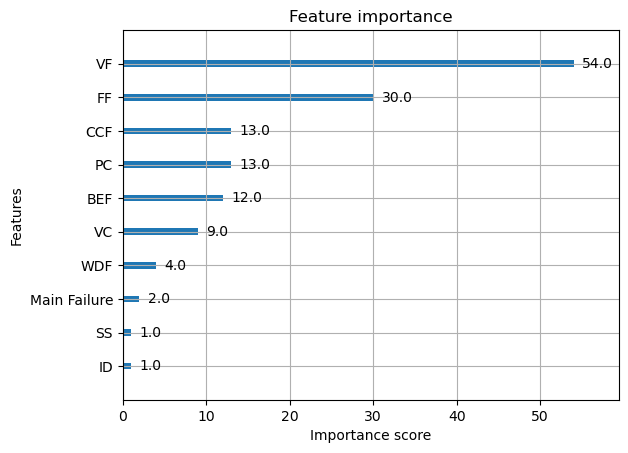

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# random seed for splitting the decision tree nodes
random_seed = 42

# renaming columns for easier inference
df = df.rename(columns={
    "Cutting speed vc [m/min]": "VC", 
    "Spindle speed n [1/min]": "SS",
    "Feed f [mm/rev]": "FF",
    "Feed rate vf [mm/min]": "VF",
    "Power Pc [kW]": "PC",
    "Cooling [%]": "Cooling",
    "Process Time [sec]": "Time",
    })

# Encode categorical variables to integer values to be used by Decision Tree
label_encoders = {}
for col in ["Material", "Drill Bit Type"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


print(df.head())

# Define features and target (x, y)
X = df.drop(columns=["FWF"])
y = df["FWF"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Initialize and train XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=random_seed)
model.fit(X_train, y_train)

# Accuracy on test set
accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type="weight")
plt.show()


# Analysis Notes:

As seen above, the graph shows the feature importance for FWF prediction. 
By evaluating the importance score of each variable, it is understood that VF (Feed rate vf [mm/min]) and FF (Feed f [mm/rev]) are the most critical aspects for predicting the wear and degradation of the drilling process. 

However, these quantities represent the same parameter but in different units. Therefore we must use just either feed rate VF or feed FF and select another feature. For this reason, since CCF and BEF represent other failing criterias (which we can not know apriori) and the power PC can be calculted throught the torque, we decide to use the feature VC (Cutting speed vc [m/min]).

Now, we hypothesize that it will be possible to make good predictions for the Flank Wear Failure, by using these two features values. The implementation of the tool is located inside the Degradation_Tool folder.

